# Optimal Transport Performance

In [146]:
import requests




In [154]:
print(r.content, 'a')

<class 'bytes'> a


In [155]:
f = open('a.npz','wb')

f.write(r.content)

13026385

In [156]:
file_path = 'a.npz'
a = np.load(file_path)

In [160]:
np.all(a['image_hists'] == npz['image_hists'])

True

In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import os
import glob
import ot
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [7]:
path='../data/images/'
band_names=['Red','Green','Blue','NIR','SWIR1','SWIR2','TEMP1','NL']

In [8]:
fps = glob.glob(f'{path}*.npz')
ims = []

for fp in fps:
    im = np.load(fp)['x']
    ims.append(im.T)

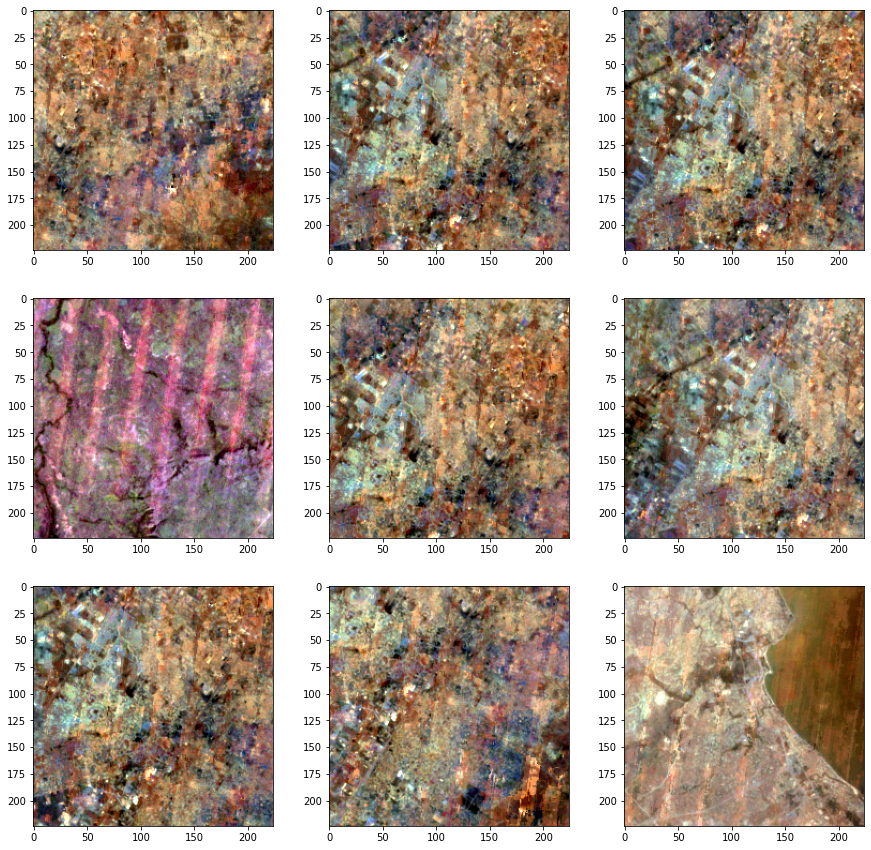

In [110]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    curr_im = ims[i][:,:,:3]
    min_val = np.percentile(curr_im, .5)
    max_val = np.percentile(curr_im, 99.5)
    curr_im = (curr_im - min_val)/(max_val-min_val)
    curr_im[curr_im > 1] = 1
    curr_im[curr_im < 0] = 0
    plt.imshow(curr_im)

In [103]:
np.array(ims).shape

(90, 224, 224, 8)

In [105]:
len(loc_dict)

19669

In [10]:
file_path = '../data/dhs_image_hists.npz'
npz = np.load(file_path)

image_hists = npz['image_hists'][:, :-1, :]
labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

In [11]:
loc_dict_path = '../data/dhs_loc_dict.pkl'

with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

In [12]:
COUNTRIES = ['angola', 'benin', 'burkina_faso', 'cameroon', 'cote_d_ivoire',
       'democratic_republic_of_congo', 'ethiopia', 'ghana', 'guinea',
       'kenya', 'lesotho', 'malawi', 'mali', 'mozambique', 'nigeria',
       'rwanda', 'senegal', 'sierra_leone', 'tanzania', 'togo', 'uganda',
       'zambia', 'zimbabwe']

In [13]:
df_data = []
for label, loc, nl_mean, nl_center in zip(labels, locs, nls_mean, nls_center):
    lat, lon = loc
    loc_info = loc_dict[(lat, lon)]
    country = loc_info['country']
    year = int(loc_info['country_year'][-4:])  # use the year matching the surveyID
    urban = loc_info['urban']
    household = loc_info['households']
    row = [lat, lon, label, country, year, urban, nl_mean, nl_center, household]
    df_data.append(row)
df = pd.DataFrame.from_records(
    df_data,
    columns=['lat', 'lon', 'wealthpooled', 'country', 'year', 'urban', 'nl_mean', 'nl_center', 'households'])

In [14]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(len(locs), dtype=np.int32)  # np.array of country labels
wealth_labels = np.zeros(len(locs), dtype=np.float32)

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    wealth_labels[i] = loc_dict[tuple(loc)]['wealthpooled']>0
    country_indices[country].append(i)

for i, country in enumerate(COUNTRIES):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

In [15]:
image_hists = image_hists/(np.max(image_hists)*1.0)

## Task:
Given reference country for which the linear regression model was trained on to predict wealth given the 8 channel image, we want to optimal transport the images for another country to this country to use the same linear regression model.

### Train Model
Let Angola be the reference country for which the model was trained on

In [35]:
idxs = country_labels==COUNTRIES.index('angola')
angola_hists = image_hists[idxs]
angola_hists_flat = angola_hists.reshape((angola_hists.shape[0], angola_hists.shape[1]*angola_hists.shape[2]))
angola_wealth = wealth_labels[idxs]
angola_hists_flat.shape, angola_wealth.shape

((855, 714), (855,))

In [36]:
angola_hists[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.26464885e-04, 1.11710648e-03,
        4.38411601e-03, 1.32366580e-02, 2.47028075e-02, 3.30073350e-02,
        5.47803726e-02, 8.64809038e-02, 1.06167271e-01, 1.08633336e-01,
        1.13691932e-01, 1.06356968e-01, 9.46168114e-02, 7.49936768e-02,
        5.21246101e-02, 3.54101678e-02, 2.81384369e-02, 1.69252171e-02,
        1.15715370e-02, 8.26237248e-03, 6.68156142e-03, 5.480145

In [37]:
ntrain = 9*idxs.sum()//10
X_train = angola_hists_flat[:ntrain,:]
X_test = angola_hists_flat[ntrain:,:]
y_train = angola_wealth[:ntrain]
y_test = angola_wealth[ntrain:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((769, 714), (769,), (86, 714), (86,))

In [38]:
clf = RandomForestClassifier(max_depth=3).fit(X_train, y_train)

In [39]:
mse_train = np.mean((y_train - clf.predict(X_train))**2)
mse_test = np.mean((y_test - clf.predict(X_test))**2)

mse_train, mse_test

(0.09492848, 0.29069766)

### Optimal transport to use this model on other countries

In [40]:
idxs = country_labels==COUNTRIES.index('benin')
benin_hists = image_hists[idxs]
benin_hists_flat = benin_hists.reshape((benin_hists.shape[0], benin_hists.shape[1]*benin_hists.shape[2]))
benin_wealth = wealth_labels[idxs]
benin_hists_flat.shape, benin_wealth.shape

((746, 714), (746,))

In [44]:
Xt = angola_hists[0].T
Xs = benin_hists[0].T
N = 10
for i in range(1, N):
    Xt = np.where(angola_hists[i].T > Xt, angola_hists[i].T, Xt)
    Xs = np.where(benin_hists[i].T > Xs, benin_hists[i].T, Xs)


Xt.shape, Xs.shape

((102, 7), (102, 7))

In [45]:
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=benin_hists[0].T)
transp_Xs_sinkhorn[transp_Xs_sinkhorn<0] = 0

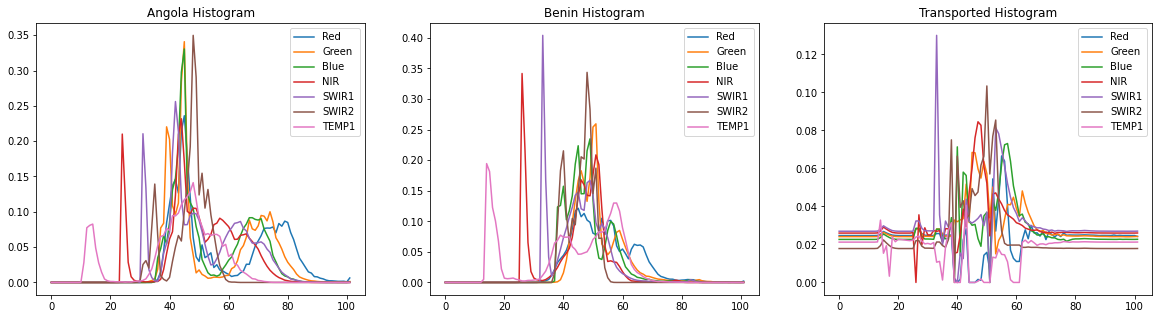

In [46]:
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(Xt, label=band_names[:-1])
plt.title('Angola Histogram')
plt.legend()
plt.subplot(1,3,2)
plt.plot(Xs, label=band_names[:-1])
plt.title('Benin Histogram')
plt.legend()
plt.subplot(1,3,3)
plt.plot(transp_Xs_sinkhorn, label=band_names[:-1])
plt.title('Transported Histogram')
plt.legend()

### Testing the Model on Transported Histogram

In [121]:
X = np.full_like(benin_hists_flat, 0)
y = benin_wealth

for i in range(X.shape[0]):
    trans = ot_sinkhorn.transform(benin_hists[i].T)
    trans[trans<0]=0
    X[i] = trans.reshape(trans.shape[0]*trans.shape[1])


In [124]:
print(angola_hists_flat.shape)

(855, 714)


In [127]:
np.mean((y - clf.predict(X))**2)

0.5053619

In [128]:
np.mean((y - clf.predict(benin_hists_flat))**2)

0.32707775